In [1]:
%%latex
\newcommand{\matr}[1]\textbf{#1}
\newcommand{\vect}[1]{\vec{#1}}

<IPython.core.display.Latex object>

In [2]:
new_analysis = True
with_obstacles = True

# Todo

1. C:/Users/chris/OneDrive/Documents/Studium/Studiengänge/Bachelor%20Physik/Bachelorarbeit/Cell-level%20canonical%20sampling%20by%20velocity%20scaling%20for%20multiparticlecollision%20dynamics%20simulations.pdf formula (2), $t+\Delta t$ The velocity scaling might not be right because of this mistake?
2. Add virtual particles where the obstacles are.
3. Clean code. It's hardly readable. Half done
4. Maybe remove the shared pointers, theyre stupid actually.
5. For \_obstacles, you can actually do it. (make unique f.ex? or just use two vectors for wall and obstacles) They only appear in pipe and simulation, but particles need to stay in simulation, and particles need obstacles to check if they are in bounds initially.
6. For interactors too. (also pipe)
7. _Remove the Xoshiros? instead use MT? DEFINITELY REMOVE THEM BECAUSE OF CONCURRENCY ISSUES_ **Done**
8. Search for TODO
9. check velocity for before and after thermostat/ maybe adjust temperature?
10. at() of map now throws. this should be in grid or smth. fix it.

# To my dear supervisors

Dear Professor Likos!
Dear Dr. Bianchi!
Dear Professor Kahl!

I want to thank Professor Kahl for taking over the duty of supervising my bachelor's thesis. I'm very relieved that (hopefully) the administrative part has been taken care of. Dr. Bianchi, thank you very much again for organising everything.

A quick recap: This is the format I've chosen to report my progress. I'll periodically send a report that is generated by jupyter notebook (a science & analysis environment for python). The notebook is here for writing part of my thesis, as well as analyzing the data. The code is written in C++. So please don't worry if not everything looks good yet - the formatting, and improving the citation style as well as other things will be done later, when the bachelor's has mostly been finished.

Last time I implemented the streaming step and did some work on random generators, as well as finding my way into C++ again. It has been quite some time and I'm happy to report some progress.

This time the MPCD barebones should be completely working (streaming + collision + gridshift). Work was done on parallelizing the code (far too much), but this has been scrapped for now. Additionally, I've written a lot of analyzing code in python that will be there to generate some hopefully interesting plots once everything has been implemented. The code was tested, in my opinion, quite a lot, and I think there should be no issues. But if you find anything that looks suspicious from this report, just tell me right away.

Please stay in good health. Yours,

Chris

# MPCD simulation of polymers in solution

This notebook will serve as the documentation of our efforts and results for my Bachelor's Thesis. The goal of this thesis will be the study of short/long-chained polymers in a liquid thats flowing around obstacles. The liquid will be simulated with MPCD, or "Multi Particle Collision Dynamics".

I chose the language C++ for its familiar object-oriented nature and its proven execution-time. Output of the simulation will mostly be analysed in Python, specifically with Jupyter Notebook for a blend of beautiful visualizations and convenience. For simplification, the situation will be studied in 2D. The situation we specifically discussed is shown below.

![Situation](Assets/MPCD_Situation.png)

# Discussed questions

Are there other people I can contact for the programming/implementation details? - _Max Liebetreu, Andreas Zöddl_

How do I model the obstacles?, the walls? = the same? Many particles, large molecules? circles? - _Stick boundary conditions: velocity gets flipped when colliding. Also: virtual particles for cell partially filled by wall. Interaction with cylindrical obstacles is explained in Arash's paper._

How should I initialize the velocities? How large can they be without distorting the simulation? - _Maxwell Boltzmann with $2/2 k_B T$ (2D)_

If particles drift too far out of bounds, should they be destroyed, and should then new ones be created to keep the number constant? In other words, should there be a particle source? - _Yes. The situation is now fixed from 100 - 400 : 20 - 50 aspect ratio. When particles go out of those bounds, they are "teleported" to the other side. This means that it loops around, as if it was a ring, instead of a 2d pipe._

How can I test if my simulation is right? See if some parameter can be tuned to one of an experiment? How should we go about this? - _See if we get parabolic velocity profile for the 2d situation, after walls have been added. Also check conservation of energy._

Will we go to 3D? - _For the Bachelor's, we will keep it 2D._

# Open Questions

On what order should $D >> d$ in the drawing be? (see above) - _Still open._

Half discussed: How large can the timestep be? - _The timestep will be a function of the other parameters. In Arash's paper, a unit of time $\tau = \sqrt{\frac{m a^2}{k_B T}}$ was chosen and from this somehow a timestep was derived. For now, I'll take the same unit of time and make the MPCD timestep 1/10 of that (just like Arash)._ - Is that okay?

How should I choose the units, e.g. mass, Temperature? (In Arash's paper f.ex., T=1 was chosen) At the time I'm working with the mass of H2O[kg] and Body Temperature[K]. - _Still open._


https://en.wikipedia.org/wiki/Hagen%E2%80%93Poiseuille_equation

Does the equation for pressure difference hold?

In standard fluid-kinetics notation:[5][6][7]

{\displaystyle \Delta p={\frac {8\mu LQ}{\pi R^{4}}}={\frac {8\pi \mu LQ}{A^{2}}}}{\displaystyle \Delta p={\frac {8\mu LQ}{\pi R^{4}}}={\frac {8\pi \mu LQ}{A^{2}}}}
where:

The ratio of length to radius of a pipe should be greater than one forty-eighth of the Reynolds number for the Hagen–Poiseuille law to be valid.[9] If the pipe is too short, the Hagen–Poiseuille equation may result in unphysically high flow rates; the flow is bounded by Bernoulli's principle, under less restrictive conditions, by

{\displaystyle \Delta p={\frac {1}{2}}\rho v_{\text{max}}^{2}={\frac {1}{2}}\rho \left({\frac {Q_{\max }{}}{\pi R^{2}}}\right)^{2}\,\,\,\rightarrow \,\,\,Q_{\max }{}=\pi R^{2}{\sqrt {\frac {2\Delta p}{\rho }}},}{\displaystyle \Delta p={\frac {1}{2}}\rho v_{\text{max}}^{2}={\frac {1}{2}}\rho \left({\frac {Q_{\max }{}}{\pi R^{2}}}\right)^{2}\,\,\,\rightarrow \,\,\,Q_{\max }{}=\pi R^{2}{\sqrt {\frac {2\Delta p}{\rho }}},}
because it's impossible to have less-than-zero (absolute) pressure (not to be confused with gauge pressure) in an incompressible flow.

# Next Steps

1. _Check the conservation of energy, momentum, do the grid shift or the wall + particles + obstacles shift. - _Done.__
2. Constant Force that pull the particles in +x direction + Gamma cell level thermostat
3. Implement Wall logic, check if we get a parabolic flow profile.
4. Implement obstacle logic.
5. Polymers MD?

# Introduction

Multiparticle collision dynamics (MPCD), also known as Stochastic Rotation Dynamics (SRD)[@winkl2009] is a technique originally introduced to study the dynamics of complex fluids such as polymers in solution. Besides MPCD, there exist other mesoscopic models that have been constructed for this purpose, such as Langevin, Direct Simulation Monte Carlo and lattice Boltzmann methods.[@malev1999] We only concern ourselves with the application of MPCD, it follows that any comparison between methods are out of the scope of this thesis.

The MPCD technique models the fluid using particles, their positions and velocities are treated as continuous variables. The system is divided up into cells that have no restriction on the number of particles, each of the cells is part of a regular lattice. The dynamics is split into two parts: Particle streaming and multiparticle collision dynamics. Particle streaming is treated exactly for each particle in the system, while the collision step is approximated on a cell level. The multiparticle collision dynamics conserves mass, momentum and energy and leads to the correct hydrodynamical equations.[@malev1999] The streaming and collision step are described in more detail in (TODO: section numbering).

# The MPCD algorithm

The system we are modelling consists of $N$ particles with mass $m$, continuous position $\vec{r_{i}}$ and velocity $\vec{v_{i}}$, where $i \in \{1, 2, \dots, N\}$. One timestep $\Delta t$ shall correspond to having calculated all the new particle positions and velocities in the streaming and collision steps, respectively. For each of the $N$ particles, the streaming and collision steps are applied, and this pattern is repeated until the wanted number of timesteps have elapsed.

## The streaming step

The streaming step is very straightforward. The particle positions are simply updated according to

\begin{equation}
\vect{r_{i}} \rightarrow \vect{r_{i}} + \Delta t \cdot \vect{v_{i}}\textrm{,}
\end{equation}

where $\Delta t$ is a small time interval.[@winkl2009][@malev1999]

## The collision step

The collision step is somewhat more complicated. It involves the mean velocity of all particles in a particular cell, $\vect{V_c}$, the velocity of the particle $i$, $\vec{v_i}$, and a rotation matrix $\matr{R}(\alpha)$. The vector $\vect{v_i}$ is rotated relative to the mean velocity $\vect{V_c}$ of all particles in cell $c$, cell $c$ being the cell which particle $i$ belongs to. It is shown in [@malev1999] that the rule,

\begin{equation}
\vect{v_i} \rightarrow \vect{V_c} + \matr{R}(\alpha) [\vect{v_i} - \vect{V_c}] \textrm{,}
\end{equation}

conserves mass, momentum and energy under the molecular chaos assumption[@malev1999][@winkl2009, molecular chaos, p.7]. The rotation matrix $\matr{R}(\alpha)$ is a simple 2d rotation matrix

\begin{equation}
R(\alpha) = 
\left[ \begin{array}{rr}
cos(\alpha) & -sin(\alpha) \\
sin(\alpha) & cos(\alpha) \\
\end{array}\right],
\end{equation}

where $\alpha$ is sampled randomly on a per-cell basis. Furthermore, for each particle in the cell $\alpha$ flips its sign with probability $\frac{1}{2}$.[@winkl2009, (p.6)]
The mean velocity of a cell is defined as

\begin{equation}
\vect{V_c} = \frac{1}{N_c} \sum_{i=1}^{N_c} \vect{v_i} \textrm{,}
\end{equation}

where $N_c$ is the number of particles in cell c.[@malev1999]

The original MPCD algorithm was not Galilean invariant. The problem lay in the "molecular chaos" assumption, which means that particles involved in a collision have no memory of earlier encounters when colliding. This assumption is problematic when the mean free path 

\begin{equation}
\lambda = \Delta t \sqrt{\frac{k_{B}T}{m}}
\end{equation}

is small compared to the cell size $a$, since the same particles collide with each other repeatedly and thus build up correlations. When $\lambda \gg a$ Ihle and Kroll have shown that the molecular chaos assumption holds and the simulated results deviate from experimental ones only negligibly.[@ihlekroll2001, p.2][@winkl2009]

The solution to this problem is to shift all particles by the same random vector $s$ before the collision step. The components of $s$ are sampled randomly from a uniform distribution in the interval $[-\frac{a}{2}, \frac{a}{2}]$. After the collision, the particles are shifted back by the same amount.[@ihlekroll2001]

# Additions to the original MPCD Algorithm

## Interaction of fluid particles with obstacles

The fluid flows through a pipe that will be setup somewhere between 100 to 400 width, and 20 - 50 height, as can be seen in figure (TODO: figure number). In SI units, we might imagine .. (TODO: expand this section). The pipe has two parallel walls, the fluid-wall interaction is modeled using stick (or no-slip) boundary conditions. (TODO: figure). When a particle hits the wall, it goes back the same way it came there, which means that the sign of the velocity vector is flipped. Stick boundary conditions are shown in figure. (TODO: figure numbering) The fluid interacts with obstacles, which are modeled exactly like the wall, with a small complication from the geometry. To simplify this problem, the approximate collision process found in [@nikoubashman2013] is used.

![Container of MPCD fluid, with obstacles](Release/Assets/MPCD_Pipe.png)

![Reflection of particle from wall, no slip boundary conditions](Release/Assets/Wall_noslip_boundary_conditions_reflection.png)

Because of the shifting of the grid before the collision step, the cells next to the walls might be partially blocked by the wall. This partial blocking by the wall causes the cell to have, on average, less particles than it would have, had the grid not been shifted. The change in average particles distorts the collision step of particles near the wall. For more complex geometries than the one used in this thesis, the wall wont even be parallel to the grid lines, which makes this a problem even without a grid shift. To compensate this, it has been shown in (TODO: find a source) that the following process undoes the distortion.

As is shown in figure (TODO: figure numbering), imagine a cell being blocked a little bit by the wall. Let's assume that the average number of particles per cell is 4. In the first cell, we count 3 particles. What is now done, is to introduce a "virtual" particle, which we might imagine as being behind the wall, though the position of it does not matter. Jumping to the second cell, we introduce 2 "virtual particles". In general, $\bar N_c - N_c$ particles are introduced, where $\bar N_c$ is the average number of particles per cell, chosen to be an integer, and $N_c$ is the actual number of particles found in cell $c$. Their velocities are sampled from two independent normal distributions with mean $\mu = 0$ and variation $\sigma^2 = \frac{k_{B}T}{m}$, where $k_{B}$ is the boltzmann constant, $T$ is the temperature of the fluid, and $m$ is the mass of one particle.

![Undoing the distortion caused by the grid shift](Release/Assets/Wall_stick_boundary_conditions_virtual_particles.png)

## The ballistics step

The ballistics step might be called a substep of particle streaming. After the particles are moved, their position is checked for interaction with the wall or obstacles. If particles overshoot the bounds set by either the wall or obstacles, their position is set to the collision point, their velocity is reversed, subsequently they are moved for the rest of the distance they would have travelled, as explained in section. (TODO: section numbering) This means we are assuming elastic collision between the particles, the walls and obstacles.

## Constant Force

Several methods exist to model poseuille flow. Here, a gravitational approach is chosen. This means an external force acts on the unit volume of the fluid, which is given by,

\begin{equation}
\vect{F} = \rho_S g \hat x,
\end{equation}

where $\rho_S$ is the mass density of the solvent, $g$ is the acceleration constant and $\hat x$ is the unit vector in the $x$-direction. This force is incorporated into the simulation by updating the position and velocity of a particle according to the solution for constant force Newton's equations.[@nikoubashman2013]

Because now a force acts on the particles, as seen in figure (TODO figure#), additional energy is coming into the system which needs to be controlled. The tool to do this in MPCD is called a thermostat.

![Increasing energy of system. Difference in energy at timestep t vs. t=0](Release/Assets/increasing_energy.png)

## Thermostat

To counteract the heating up of the fluid by the constant force on every particle, a thermostat is needed. As described in Winkler[@winkl2009], the computationally efficient cell-level thermostat was used. For this, the macroscopic flow profile is needed. For our purposes, which is fluid flow through the cross section of a pipe with parallel walls and interaction modeled by no-slip boundary condition, we expect poseuille flow. It is calculated as, (TODO: is arashs version correct? see paper section III)

\begin{equation}
u(r) = \frac{\Delta p}{4\eta L_x} (R^2 - r^2),
\end{equation}

where $u$ is the macroscopic velocity in the x-direction, $\Delta p$ is the difference in pressure from beginning to end of the pipe, $\eta$ is the dynamic viscosity of the fluid, $L_x$ is the length of the pipe, $R$ is the radius of the pipe and $r$ is the $y$-coordinate of the particle relative to the center of the pipe.[@wiki:poseuille_equation] The situation is displayed in figure (TODO: make a figure)

TODO:
The pressure difference is on the order of $\Delta p \sim g$, where g is the acceleration constant of the force.[@nikoubashman2013]
END TODO

TODO:
The dynamic viscosity of water at body temperature is about $\eta \sim 0.6947$. END TODO

## Anything else maybe ??

# Implementing the MPCD Algorithm

## Random Number Generation

### Uniform random number generation

_This section was shortened considerably. The old version can still be found at the end of this report._

Sampling numbers from a uniform distribution is very important for MPCD. Even if we did not initialize positions randomly, but for example all at one point, arguing that after a sufficient amount of timesteps, the particles will spread out, the rotation angle still truly needs to be random, in a statistical sense.

To this end, the xoshiro256++, developed by Sebastian Vigna and David Blackman, was used. It is a fast algorithm that does well on a variety of statistical tests. The xoshiro256++ belongs to the Xoshiro algorithms, which are an extended variant of xorshift algorithms.[@vigna2019] Xoshiro stands for "Xor, Shift, Rotation" and xorshift stands for "Xor, Shift". The Xoshiro algorithms, additional to xor and bit-shift operations, incorporate bitrotation.[@unimi:xoshiro][@wiki:xorshift]

### Sampling from a normal distribution

To initialize the velocities of generated particles, a Maxwell-Boltzmann distribution must be used. In two, as well as in three dimensions, this is equivalent to the product of two, or three, independent normal distributions with mean $\mu = 0$ and variance $\sigma^2 = \frac{k_{B}T}{m}$, where $k_{B}$ is the boltzmann constant, $T$ is the temperature of the fluid, and $m$ is the mass of one particle. Thus, the velocities are sampled from normal distributions.[@wiki:maxwell_boltzmann]

For this purpose, the normal distribution of the C++ standard library was used, along with a Mersenne Twister number generator, which, although it has some shortcomings, will for all practical purposes suffice for the scope of this thesis. Although the Xoshiro is far superior to the Mersenne Twister algorithm[@vigna2019], to adapt it for this purpose did not seem worth the effort, because the difference in quality will not be visible.

## MPCD barebones algorithm

### The streaming step

_This section was shortened, since I think it does not deserve its own._

The streaming step was implemented and tested in an older version of this thesis.

### The collision step

To model the interaction of particles with each other, we implement the collision rules, as detailed in section (TODO: section numbering). To avoid some of the downfalls of the original algorithm, as detailed in section (TODO: section#), we implement a grid shift.

#### Grid shift

After particle streaming, the grid is shifted. The components of this shift, $\vect s$ are sampled from a uniform random distribution in the interval $[-\frac{a}{2},\frac{a}{2}]$. This step is necessary to restore Galilean invariance, which is violated when the molecular chaos assumption does not hold. This happens when simulating cold fluids or when using very small timesteps.[@ihlekroll2001]
The shift is undone at the end of the collision step, after the velocity of all particles has been updated.

If particles go out of the simulation bounds due to the grid shift, they reappear at the other end as described in section (TODO: section numbering). Because the wall will not align with the grid anymore, virtual particles as described in section (TODO: section numbering) have to be introduced.

#### Velocity updating

_TODO_
_Note: The floor is not rendering correctly at the moment, but it's a mistake that will be fixed in the final version._

The velocities of the particles update according to equation (TODO: numbering equ). To calculate the mean velocity $\vec{V_{c}}$ of cell $c$, first a way to assign each particle a cell has to be established. Let the indices of the cell be $(i, j)$. The position of a cell can then be calculated as $x_c = j \cdot a + s_x$ and $y_c = i \cdot a + s_y$, where $a$ is the lattice constant, $s_x$ and $s_y$ are the $x$ and $y$ components of grid shift $\vect s$. So for the indices it follows,

\begin{equation}
i = floor{\frac{y - s_y}{a}}\\
j = floor{\frac{x - s_x}{a}},
\end{equation}
where $(x,y)$ refers to the components of the particle's position vector. With this method to determine the cells, the total cell velocities and numbers of particles in each cell are calculated to obtain the mean cell velocity. Using a uniform randomly sampled rotation angle $\alpha$ and rule (TODO: numbering equ), the particles' velocities are updated.

### Testing MPCD barebones

Having implemented the essential features of the MPCD algorithm, namely the streaming and collision steps, it is time for testing it to make sure it was implemented correctly. This section will present conservation tests and visual tests. Note that there are no walls and no obstacles, no forces and no thermostat, yet.

#### Timestep animation

To inspect and understand the behavior of our simulation, an animation was created. The fluid starts out in a random state, which means that the positions and velocities of the particles are initialized randomly.

The initial state, and the one after 100 timesteps, of region $x \in (200, 240)$, $y \in (0, 20)$ can be seen below (TODO figure#). 

__An explanation of the plots__: Top left is a quiver plot, where I plot the velocity vectors of cells at their position. Top right is streamplot, where this same data is used to visualize streaming, background work (interpolation, probably) done by python. Bottom left are the particles positions in a 2d plane. Bottom right is a heatmap of number of particles per cell (will be helpful when implementing walls, because it should be less there if we don't implement virtual particles)

_The animations were sent by mail. If you did not get them and would like to see them, you can access them here: https://www.dropbox.com/sh/ih11zkpzapvd7qm/AADgbdW_ejXumRROJbCgMxaUa?dl=0_

_The animations will probably be more interesting once force, thermostat & obstacles have been implemented, but it was a good way to check the behavior of the simulation against the intuition._

In [3]:
timesteps = []
I = []
J = []
U = []
V = []
pivot = []

In [4]:
from math import floor
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os.path

path = "../Application/MPCDApplication/Data/"
csv = ".csv"
av = 10
constants = 'constants_av' + str(av) + csv

constants = pd.read_csv(path + constants)
num_timesteps = int(constants['timesteps'])

In [5]:
obstacles = None
if (with_obstacles):
    obstacles_path = path + 'constants_obstacles' + csv
    obstacles_csv = pd.read_csv(obstacles_path)
    obstacles = obstacles_csv[['x', 'y']]
    obstacle_radius = float(obstacles_csv['r'][0])

In [6]:
shown_x = float(constants['width'])
shown_y = float(constants['height'])

saved = './Saved'
saved_particles = '/particles.pkl'
file_particles = saved + saved_particles

def load_particles(path):
    columns = []
    x_columns = ['x{}'.format(it) for it in range(0, num_timesteps)]
    vx_columns = ['vx{}'.format(it) for it in range(0, num_timesteps)]
    y_columns = ['y{}'.format(it) for it in range(0, num_timesteps)]
    vy_columns = ['vy{}'.format(it) for it in range(0, num_timesteps)]
    columns.extend(x_columns)
    columns.extend(y_columns)
    columns.extend(vx_columns)
    columns.extend(vy_columns)
    particles = pd.DataFrame(columns = columns)

    if (os.path.isfile(file_particles) and not new_analysis):
        print('Found saved particles_x and particles_y files!')
        particles = pd.read_pickle(file_particles)
        print('Loaded particles files.')
    else:
        # Loading particles
        print('Loading particles ..')
        filenames_particles = glob.glob('{}*.csv'.format(path))
        it = 0
        for file in filenames_particles:
            df = pd.read_csv(file)
            particles[['x{}'.format(it), 'y{}'.format(it), 'vx{}'.format(it), 'vy{}'.format(it)]] = df[['x', 'y', 'vx', 'vy']]
            it += 1
            if (it % 10 == 0):
                print('--loaded {}'.format(it))
        particles.to_pickle(file_particles)
        it = 0
        print('Particles loaded and saved!\n')
        # Particles loaded
    return particles


particles_path = '{parent}particles_av{av}'.format(parent = path, av=av)    
particles = load_particles(path = particles_path)

Loading particles ..
--loaded 10
--loaded 20
--loaded 30
--loaded 40
--loaded 50
--loaded 60
--loaded 70
--loaded 80
--loaded 90
--loaded 100
Particles loaded and saved!



In [7]:
cell_dim = float(constants['cell_dim'])
width = float(constants['width'])
height = float(constants['height'])
shown_cols = floor(width / cell_dim)
shown_rows = floor(height / cell_dim)

saved = './Saved'
saved_cells = '/cells.pkl'
file_cells = saved + saved_cells

columns = ['i', 'j', 'meanX', 'meanY', 'num']

def load_cells(path, columns, shown_rows, shown_cols):
    
    index = ['t']
    if (os.path.isfile(file_cells)):
        cells = pd.read_pickle(file_cells)
        #print(cells)
        #cells.set_index(index, inplace=True)
    else:
        # Loading cells
        print('Loading cells')
        
        cells_timesteps = []
        
        it = 0
        filenames_cells = glob.glob('{}*.csv'.format(path))
        for file in filenames_cells:
            df = pd.read_csv(file)
            cells_timesteps.append(df)
            #df[[i,j]] = (df[[i,j]] + 1/2) * cell_dim
            #print(df.head())
            it += 1
            if (it % 10 == 0):
                print('--loaded {}'.format(it))
        #cells.to_pickle(file_cells)
        print('Cells loaded and saved!\n')
        # Cells loaded
        return cells_timesteps
    
def prepare_cells(cells_timesteps, columns, shown_rows, shown_cols):
    # Preparing cell values
    print('Preparing cell values ..')

    array_i = np.arange(0, shown_rows)
    array_j = np.arange(0, shown_cols)
    I,J = np.meshgrid(array_j, array_i)

    U = []
    V = []

    i = columns[0]
    j = columns[1]
    vx = columns[2]
    vy = columns[3]
    num = columns[4]

    pivots = []
    for df in cells_timesteps:
        # only the rows and cols above 0
        # and below shown_rows, shown_cols
        # this is to 
        # --1. no vaccuum around simulated region
        # --2. I,J are fixed size
        U_inner = []
        V_inner = []
        for it in array_i: # TODO: check this code something seems foul (row, cols, but only using rows)
            temp = df.loc[df[i] == it]
            u = np.array(temp[vx])
            U_inner.append(u)
            v = np.array(temp[vy])
            V_inner.append(v)
        U.append(np.array(U_inner))#, dtype = object))
        V.append(np.array(V_inner))#, dtype = object))

        pivot = df.pivot(index = i, columns = j, values = num)
        pivots.append(pivot)

    print('Cell preparation complete!')
    return I,J,U,V, pivots
    # Cell preparation complete


cells_path = path + 'cells_av{}'.format(av)
cells_timesteps = load_cells(cells_path, columns, shown_rows, shown_cols)
I,J,U,V,pivots = prepare_cells(cells_timesteps, columns, shown_rows, shown_cols)

Loading cells
--loaded 10
--loaded 20
--loaded 30
--loaded 40
--loaded 50
--loaded 60
--loaded 70
--loaded 80
--loaded 90
--loaded 100
Cells loaded and saved!

Preparing cell values ..
Cell preparation complete!


Plotting data ..
Data plotted and saved!


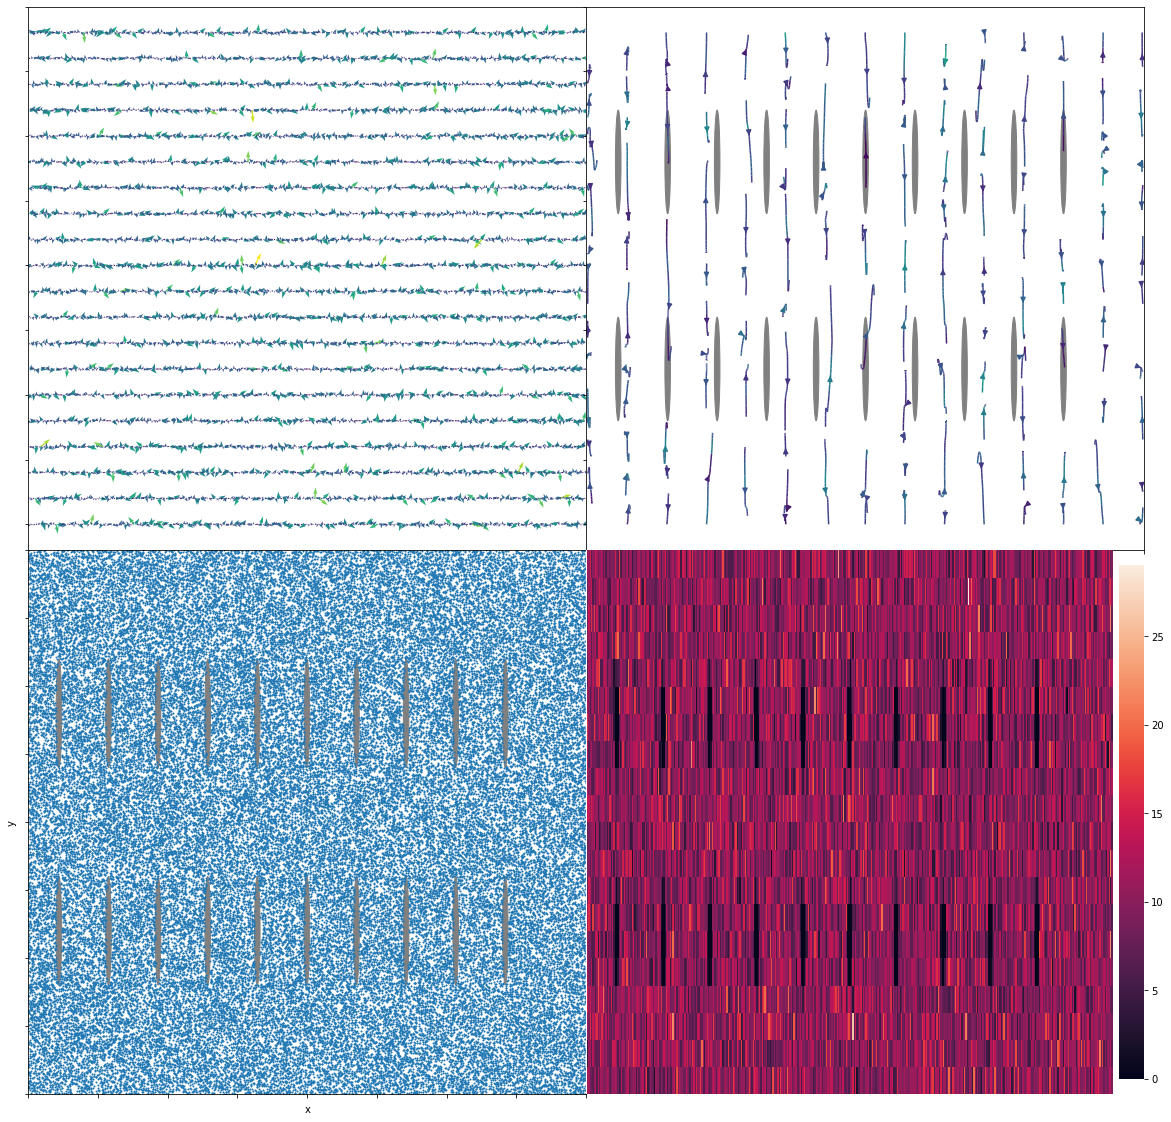

In [8]:
# Plotting
#with (sns.plotting_context(sns.set())):
x_0_region = 0
x_max_region = int(constants['width'])
y_0_region = 0
y_max_region = int(constants['height'])

streamplot_density = [0.5, 1]

print('Plotting data ..')
fig = plt.figure(figsize=(20,20))
ax = [fig.add_subplot(2,2,i+1) for i in range(4)]

for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    #a.set_aspect('equal')
    
fig.subplots_adjust(wspace=0, hspace=0)

color = np.sqrt(U[0]**2 + V[0]**2)
point_size = 1

#circles = []
if with_obstacles:
    for index, o in obstacles.iterrows():
        circle1 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'gray')
        circle2 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'gray')
        #circle3 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'black')
        #circles.append(circle)
        ax[1].add_artist(circle1)
        ax[2].add_artist(circle2)
        #ax[3].add_artist(circle3)
        #ax[0].xaxis.set_ticks([])
#ax[0].yaxis.set_ticks([])
ax[0].quiver(I, J, U[0], V[0], color)
ax[0].set(xlim=(x_0_region-1,x_max_region), ylim=(y_0_region-1,y_max_region))

#ax[1].xaxis.set_ticks([])
#ax[1].yaxis.set_ticks([])
ax[1].streamplot(I, J, U[0], V[0], color=color, density = streamplot_density) # grid
ax[1].set(xlim=(x_0_region-1,x_max_region), ylim=(y_0_region-1,y_max_region))

#ax[2].xaxis.set_ticks([])
#ax[2].yaxis.set_ticks([])
ax[2].plot(particles['x0'], particles['y0'], "o", markersize = point_size)
if with_obstacles:
    sns.scatterplot(ax = ax[2], x = obstacles['x'], y = obstacles['y'], s = obstacle_radius)
ax[2].set(xlim=(x_0_region, x_max_region), ylim=(y_0_region,y_max_region))

#ax[3].xaxis.set_ticks([])
#ax[3].yaxis.set_ticks([])
#img = ax[3].imshow(pivot, cmap='hot')
#fig.colorbar(img, ax=ax[3], fraction=0.046, pad=0.005)
sns.heatmap(pivots[0], ax=ax[3], xticklabels = False, yticklabels = False, cbar_kws={"fraction": 0.046, "pad": 0.01})
ax[3].set(xlim=(x_0_region-1,x_max_region), ylim=(y_0_region,y_max_region))
#ax[3].xticks('')
#ax[3].yticks('')
ax[3].set_ylabel('')
ax[3].set_xlabel('')
#ax[1,1].imshow(pivot, cmap='hot')

plt.savefig("Assets/initial_region.png")
#plt.close()
print('Data plotted and saved!')

![Initial State of region with barebones MPCD implementation](Assets/initial_region.png)

Plotting data ..
Data plotted and saved!


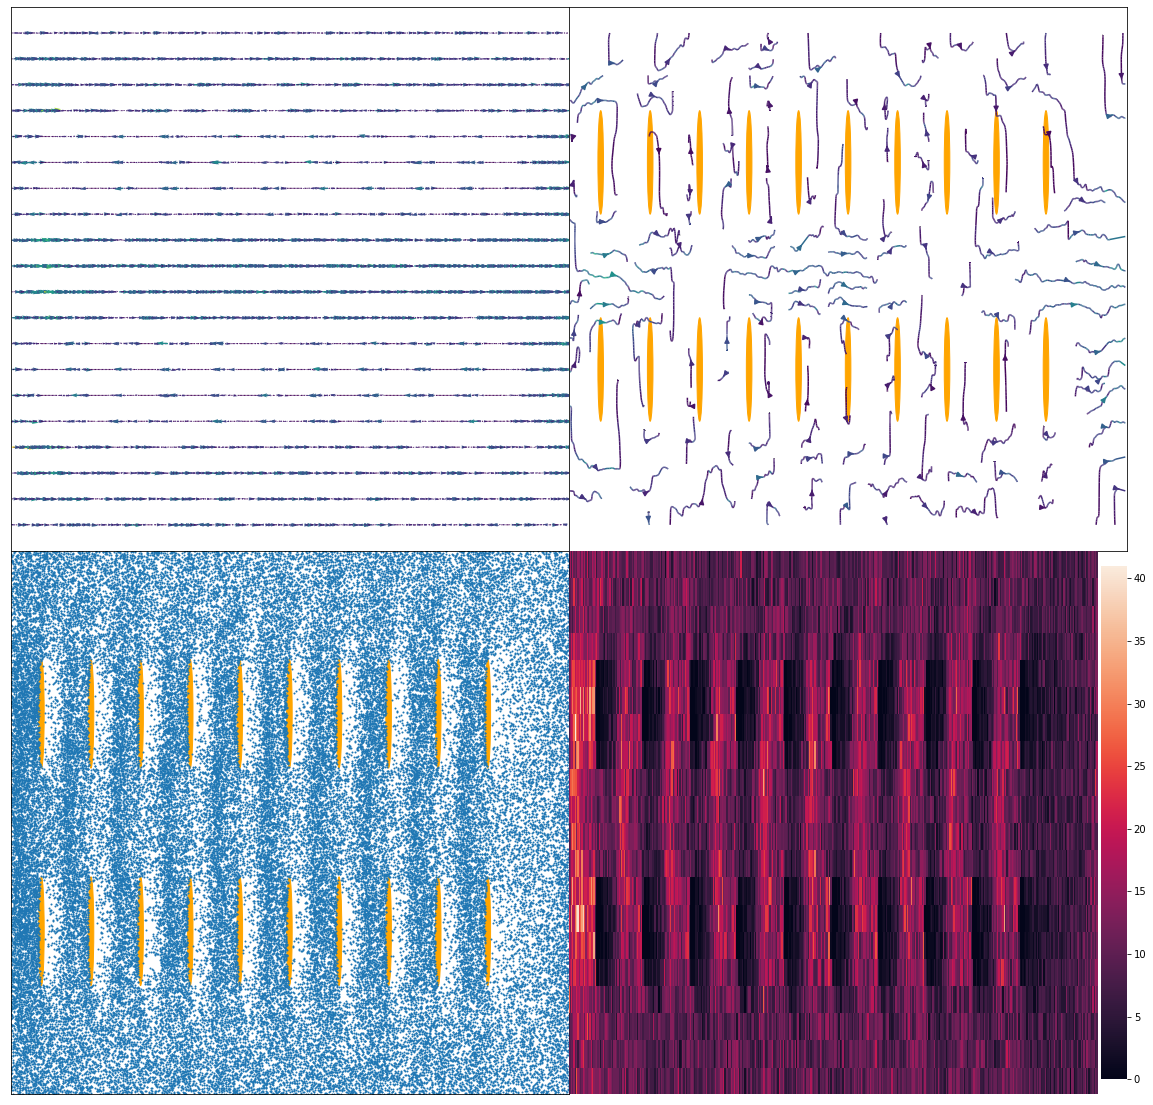

In [9]:
print('Plotting data ..')
fig = plt.figure(figsize=(20,20))
ax = [fig.add_subplot(2,2,i+1) for i in range(4)]

timesteps = int(constants['timesteps']) - 1

for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    #a.set_aspect('equal')
    
fig.subplots_adjust(wspace=0, hspace=0)

color = np.sqrt(U[timesteps]**2 + V[timesteps]**2)
point_size = 1

if with_obstacles:
    for index, o in obstacles.iterrows():
        circle1 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'orange')
        circle2 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'orange')
        #circle3 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'black')
        #circles.append(circle)
        ax[1].add_artist(circle1)
        ax[2].add_artist(circle2)
        #ax[3].add_artist(circle3)
        #ax[0].xaxis.set_ticks([])

ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[0].quiver(I, J, U[timesteps], V[timesteps], color)
ax[0].set(xlim=(x_0_region-1,x_max_region), ylim=(y_0_region-1,y_max_region))

ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[1].streamplot(I, J, U[timesteps], V[timesteps], color=color, density=streamplot_density) # grid
ax[1].set(xlim=(x_0_region-1,x_max_region), ylim=(y_0_region-1,y_max_region))

ax[2].xaxis.set_ticks([])
ax[2].yaxis.set_ticks([])
ax[2].plot(particles['x{}'.format(timesteps)], particles['y{}'.format(timesteps)], "o", markersize = point_size)
ax[2].set(xlim=(x_0_region,x_max_region), ylim=(y_0_region,y_max_region))

ax[3].xaxis.set_ticks([])
ax[3].yaxis.set_ticks([])
#img = ax[3].imshow(pivot, cmap='hot')
#fig.colorbar(img, ax=ax[3], fraction=0.046, pad=0.005)
sns.heatmap(pivots[timesteps], ax=ax[3], xticklabels = False, yticklabels = False, cbar_kws={"fraction": 0.046, "pad": 0.005})
ax[3].set(xlim=(x_0_region,x_max_region), ylim=(y_0_region,y_max_region))
#ax[3].xticks('')
#ax[3].yticks('')
ax[3].set_ylabel('')
ax[3].set_xlabel('')
#ax[1,1].imshow(pivot, cmap='hot')

plt.savefig("Assets/stationary_region.png")
#plt.close()
print('Data plotted and saved!')

![Ending (maybe stationary) state of region with barebones MPCD implementation](Assets/stationary_region.png)

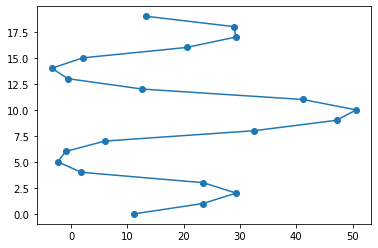

In [10]:
rowsums = [row.sum()/len(row) for row in U[timesteps]]
plt.plot(rowsums, range(len(rowsums)), "o-")
plt.savefig("Assets/velocity_profile.png")
#plt.close()

![Ending velocity profile](Release/Assets/velocity_profile.png)

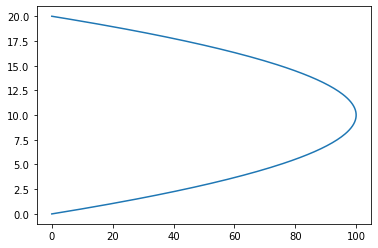

In [11]:
import numpy as np
import matplotlib.pyplot as plt
# setting the x - coordinates 
x = np.arange(0, 20.1, 0.1) 
# setting the corresponding y - coordinates 
R = 10


y = (R * R) - (x - R)**2
#y = R * R - (x - R)**2

plt.plot(y, x)

# Histograms velocity

## t = 0

(array([8.0000e+00, 9.7000e+01, 1.2820e+03, 7.4750e+03, 2.0745e+04,
        2.7350e+04, 1.7175e+04, 5.0700e+03, 7.5000e+02, 4.8000e+01]),
 array([-4.68911 , -3.797773, -2.906436, -2.015099, -1.123762, -0.232425,
         0.658912,  1.550249,  2.441586,  3.332923,  4.22426 ]),
 <BarContainer object of 10 artists>)

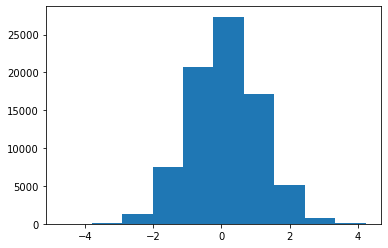

In [12]:
last_vels = particles['vx{}'.format(0)]
plt.hist(last_vels)

C:\Users\chris\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='vy0', ylabel='Density'>

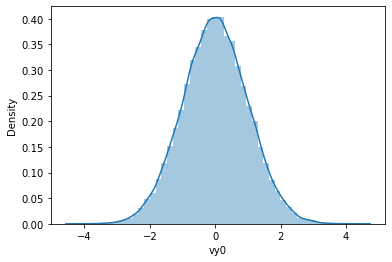

In [13]:
last_vels = particles['vy{}'.format(0)]
sns.distplot(last_vels)

## t = timesteps, f.ex. 200 or 500

C:\Users\chris\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='vx99', ylabel='Density'>

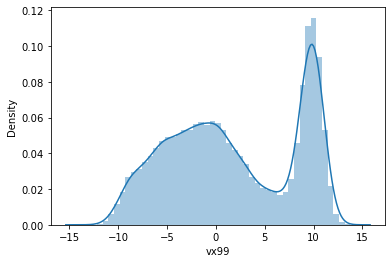

In [14]:
last_vels = particles['vx{}'.format(timesteps)]
sns.distplot(last_vels)

C:\Users\chris\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='vy99', ylabel='Density'>

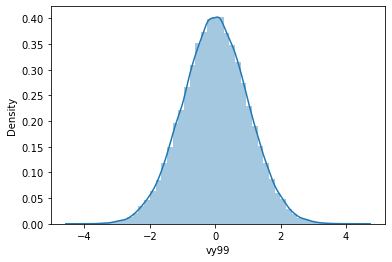

In [15]:
last_vels = particles['vy{}'.format(timesteps)]
sns.distplot(last_vels)

# Temperature of solvent

hmmmmm?

<AxesSubplot:>

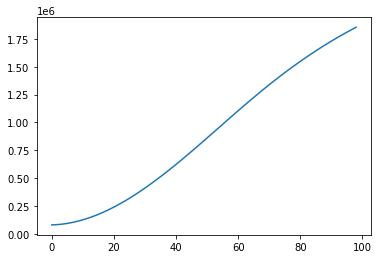

In [16]:
v_2_t = [particles[['vx{}'.format(t), 'vy{}'.format(t)]]**2 for t in range(timesteps)]
avg_v_2_t = [v_2_particles.sum().sum() for v_2_particles in v_2_t]

particle_mass = float(constants['particle_mass'])

temp_t = np.array(avg_v_2_t) * 0.5 * particle_mass
sns.lineplot(data=temp_t)

# Animations

In [17]:
from matplotlib import animation
print('Animating Quiver ...\n')

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(x_0_region, x_max_region), ylim=(y_0_region, y_max_region))

quiv = ax.quiver(I, J, 10**-12*U[0], 10**-12*V[0], scale = 1) #10**-5*U10**-5*V

# initialization function: plot the background of each frame
def init():
    #quiv.set_data([], [], [], [])
    return quiv,

# animation function.  This is called sequentially
def animate(it, quiv, I, J):
    #color = np.sqrt(U[it]**2 + V[it]**2)
    quiv.set_UVC(10**-12*U[it], 10**-12*V[it]) #*10**-5*
    if (it % 10 == 0):
        print('--Created {} frame.\n'.format(it))
    #quiv.set_color(color)
    return quiv,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, fargs = (quiv, I, J),#init_func=init,
                               frames=timesteps, blit=False)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('./Assets/quiver_animation.mp4', fps=5) #extra_args=['-vcodec', 'libx264'])
print('Animated and saved!')

plt.close()

Animating Quiver ...

--Created 0 frame.

--Created 0 frame.

--Created 10 frame.

--Created 20 frame.

--Created 30 frame.

--Created 40 frame.

--Created 50 frame.

--Created 60 frame.

--Created 70 frame.

--Created 80 frame.

--Created 90 frame.

Animated and saved!


In [18]:
from matplotlib import animation
import seaborn as sns

print('Animating Heatmap ...\n')

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(x_0_region, x_max_region), ylim=(y_0_region, y_max_region))
sns.heatmap(pivots[0], square = True, xticklabels = False, yticklabels = False, cbar = False)#,cbar_kws={"fraction": 0.046, "pad": 0.005})

# initialization function: plot the background of each frame
def init():
    plt.clf()
    ax = sns.heatmap(pivots[0], square = True, xticklabels = False, yticklabels = False, cbar = False)#,cbar_kws={"fraction": 0.046, "pad": 0.005})
    #return heatmap,

# animation function.  This is called sequentially
def animate(it):
    plt.clf()
    ax = sns.heatmap(pivots[it], square = True, xticklabels = False, yticklabels = False, cbar = False)#,cbar_kws={"fraction": 0.046, "pad": 0.005})
    ax.set_xlim((x_0_region, x_max_region))
    ax.set_ylim((y_0_region, y_max_region))
    if (it % 10 == 0):
        print('--Created {} frame.\n'.format(it))
    #return heatmap

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=timesteps)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('./Assets/heatmap_animation.mp4', fps=5) #extra_args=['-vcodec', 'libx264'])
print('Animated and saved!')

plt.close()

Animating Heatmap ...

--Created 0 frame.

--Created 10 frame.

--Created 20 frame.

--Created 30 frame.

--Created 40 frame.

--Created 50 frame.

--Created 60 frame.

--Created 70 frame.

--Created 80 frame.

--Created 90 frame.

Animated and saved!


In [19]:
from matplotlib import animation

print('Animating particles ...')
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(x_0_region, x_max_region), ylim=(0, y_max_region))
scatter, = ax.plot(particles['x0'], particles['y0'], "o", markersize = point_size)

x = 'x'
y = 'y'

# initialization function: plot the background of each frame
def init():
    #quiv.set_data([], [], [], [])
    return scatter,

# animation function.  This is called sequentially
def animate(it):
    scatter.set_xdata(particles[x + str(it)])
    scatter.set_ydata(particles[y + str(it)])
    if (it % 10 == 0):
        print('--Created {} frame.\n'.format(it))
    return scatter,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, #init_func=init,
                               frames=timesteps, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('./Assets/scatterplot_animation.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
print('Animated and saved!')

plt.close()

Animating particles ...
--Created 0 frame.

--Created 0 frame.

--Created 0 frame.

--Created 10 frame.

--Created 20 frame.

--Created 30 frame.

--Created 40 frame.

--Created 50 frame.

--Created 60 frame.

--Created 70 frame.

--Created 80 frame.

--Created 90 frame.

Animated and saved!


In [20]:
from matplotlib import animation

print('Animating Streamplot ...\n')

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(x_0_region, x_max_region), ylim=(y_0_region, y_max_region))
color = np.sqrt(U[0]**2 + V[0]**2)
stream = ax.streamplot(I, J, U[0], V[0], color=color, density = streamplot_density)

# initialization function: plot the background of each frame
def init():
    #quiv.set_data([], [], [], [])
    return stream

# animation function.  This is called sequentially
def animate(it):
    ax.collections = [] # clear lines streamplot
    ax.patches = [] # clear arrowheads streamplot
    color = np.sqrt(U[it]**2 + V[it]**2)
    stream = ax.streamplot(I, J, U[it], V[it], color=color, density = streamplot_density)
    if (it % 10 == 0):
        print('--Created {} frame.\n'.format(it))
    return stream

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, #init_func=init,
                               frames=timesteps, blit=False)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('./Assets/streamplot_animation.mp4', fps=5) #extra_args=['-vcodec', 'libx264'])
print('Animated and saved!')

plt.close()

Animating Streamplot ...

--Created 0 frame.

--Created 0 frame.

--Created 10 frame.

--Created 20 frame.

--Created 30 frame.

--Created 40 frame.

--Created 50 frame.

--Created 60 frame.

--Created 70 frame.

--Created 80 frame.

--Created 90 frame.

Animated and saved!


#### Conservation of number of particles

The number of particles is (just for convenience) plotted and it stays constant.

In [21]:
import matplotlib.pyplot as plt
nums = []
for pivot in pivots:
    nums.append(sum(sum(lis) for lis in pivot.values))

plt.plot(nums)
plt.title('Variation in number of particles with timesteps')
plt.ylabel('Number of Particles')
#plt.ylim((79990, 80010))
plt.xlabel('Timestep')
plt.savefig('./Assets/number_particles.png')
plt.close()

![Constant number of particles](Assets/number_particles.png)

#### Conservation of momentum

Because the angle of rotation in the collision step is chosen randomly, and the streaming step does not change momentum, in a large system momentum should be conserved. The velocities of particles were taken and added up. The base momentum is the initial momentum, the error (or variation) from this base is plotted below.

In [22]:
momentum_x = []
momentum_y = []
for it in range(0, timesteps-1):
    vx = sum(particles['vx{}'.format(it)])
    vy = sum(particles['vy{}'.format(it)])
    momentum_x.append(vx)
    momentum_y.append(vy)

base_momentum_x = momentum_x[0]
base_momentum_y = momentum_y[0]
error_x = [base_momentum_x - m for m in momentum_x]
error_y = [base_momentum_y - m for m in momentum_y]
plt.plot(error_x)
plt.title('Variation in x-Velocity, initially: {}'.format(round(base_momentum_x, 2)))
plt.xlabel('Timestep')
plt.ylabel('x-Velocity')
plt.savefig('./Assets/x_velocity_variation.png')
plt.close()
plt.plot(error_y)
plt.title('Variation in y-Velocity, initally: {}'.format(round(base_momentum_y, 2)))
plt.xlabel('Timestep')
plt.ylabel('y-Velocity')
plt.savefig('./Assets/y_velocity_variation.png')
plt.close()
plt.plot(error_x, error_y, "o", markersize = 3)
plt.title('Variation in velocity')
plt.xlabel('Variation in x-velocity')
plt.ylabel('Variation in y-velocity')
plt.savefig('./Assets/velocity_variation.png')
plt.close()
# -----------------------------------


#plt.close()

![Variation in x-velocity throughout simulation](Assets/x_velocity_variation.png)

![Variation in y-velocity throughout simulation](Assets/y_velocity_variation.png)

![Variation in velocity throughout simulation](Assets/velocity_variation.png)

Error $\sim 10^{-5}$

#### Energy

The collision step of the MPCD algorithm conserves energy _locally_, which is to say on a cell level. [@winkl2009] The energy should also be conserved globally, since no force is acting upon the particles _yet_, the streaming and collision steps conserve energy, and the particle number remains the same.

To inspect this, the energy of every particle is added up. The base energy is the initial energy, the error (or variation from this base) is calculated and plotted below.

In [23]:
'''
def square(lis):
    for e in lis:
        yield e**2

xvels_squared = []
for cell_xvels in U:
    xvels_squared.append(sum(sum(square(lis)) for lis in cell_xvels))
#print(xvels)
yvels_squared = []
for cell_yvels in V:
    yvels_squared.append(sum(sum(square(lis)) for lis in cell_yvels))
assert(len(xvels) == len(yvels))
it = 0
energy_cell_level = []
mass = 2.988e-26
for xvel_squared in xvels_squared:
    yvel_squared = yvels_squared[it]
    energy_cell_level.append((xvel_squared + yvel_squared)) # might add mass here
    
plt.plot(energy_cell_level)
plt.title('Variation in energy, cell method')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.savefig('./Assets/constant_energy_cellcalc.png')
plt.close()
'''

"\ndef square(lis):\n    for e in lis:\n        yield e**2\n\nxvels_squared = []\nfor cell_xvels in U:\n    xvels_squared.append(sum(sum(square(lis)) for lis in cell_xvels))\n#print(xvels)\nyvels_squared = []\nfor cell_yvels in V:\n    yvels_squared.append(sum(sum(square(lis)) for lis in cell_yvels))\nassert(len(xvels) == len(yvels))\nit = 0\nenergy_cell_level = []\nmass = 2.988e-26\nfor xvel_squared in xvels_squared:\n    yvel_squared = yvels_squared[it]\n    energy_cell_level.append((xvel_squared + yvel_squared)) # might add mass here\n    \nplt.plot(energy_cell_level)\nplt.title('Variation in energy, cell method')\nplt.xlabel('Timestep')\nplt.ylabel('Energy')\nplt.savefig('./Assets/constant_energy_cellcalc.png')\nplt.close()\n"

In [24]:
energy = []
vx_squared = particles[['vx{}'.format(it), 'vy{}'.format(it)]]
for it in range(0, timesteps-1):
    vx_squared = sum(particles['vx{}'.format(it)]**2)
    vy_squared = sum(particles['vy{}'.format(it)]**2)
    energy.append(np.sqrt(vx_squared + vy_squared))

base_energy = energy[0]
error = [base_energy - e for e in energy]
plt.plot(error)
plt.title('Variation in energy, initially: {}'.format(base_energy))
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.savefig('./Assets/constant_energy.png')
plt.close()


In [25]:
energy = []
for it in range(0, timesteps-1):
    vx_squared = sum(particles['vx{}'.format(it)]**2)
    vy_squared = sum(particles['vy{}'.format(it)]**2)
    energy.append(np.sqrt(vx_squared + vy_squared))

base_energy = energy[0]
error = [e - base_energy for e in energy]
plt.plot(error)
plt.title('Difference to inital energy')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.savefig('./Assets/increasing_energy.png')
plt.close()


![Constant energy throughout simulation](Assets/constant_energy.png)

Error $\sim 10^{-8}$

## Converting to Word doc (others possible too, f.ex. .tex)

In [26]:
# just do it manually, it works on anaconda env datascience

import subprocess
#automatic document conversion to markdown and then to word
#first convert the ipython notebook paper.ipynb to markdown
subprocess.run("jupyter nbconvert --to markdown thesis.ipynb --output-dir='./Generated'") #--output-dir='./Generated'
#next remove code
path = "./Generated/thesis.md"
with open(path, "r") as f:
    lines = f.readlines()
    idx = []
    idx_files = []
    for i, line in enumerate(lines):
        if (line.startswith("```")):
            idx.append(i)
        if ("thesis_files" in line):
            c = line.find("thesis_files")
            lines[i] = line[0:c] + "" + line[c:]

idx = sorted(idx, reverse=True) # reverse order so not deleting lines and then missing others
for current, previous in zip(idx[::2], idx[1::2]):
    print("Deleting {p}:{c}".format(p=previous, c=current+1))
    print('\n'.join(lines[previous:current+1]))
    del lines[previous:current+1]
    
with open(path, "w") as f:
    #f.write("\\newcommand{\matr}[1]\\textbf{#1}")
    #f.write("\\newcommand{\\vect}[1]{\\vec{#1}}")
    for line in lines:
        f.write("%s" % line)
#next convert markdown to ms word
conversion_tex = "pandoc -s ./Generated/thesis.md -o ./Generated/thesis.tex --filter pandoc-citeproc --bibliography=\"list.bib\" --csl=\"apa.csl\""
subprocess.run(conversion_tex)
conversion_pdf = "pandoc -s ./Generated/thesis.md -o ./Generated/thesis.pdf --filter pandoc-citeproc --bibliography=\"list.bib\" --csl=\"apa.csl\""
subprocess.run(conversion_pdf)
# LATEX TO DOCX pandoc -s math.tex -o example30.docx

Deleting 1310:1313
```python



```

Deleting 1298:1306
```javascript

%%javascript

MathJax.Hub.Queue(

  ["resetEquationNumbers", MathJax.InputJax.TeX],

  ["PreProcess", MathJax.Hub],

  ["Reprocess", MathJax.Hub]

);

```

Deleting 1288:1294
```javascript

%%javascript

MathJax.Hub.Config({

    TeX: { equationNumbers: { autoNumber: "AMS" } }

});

```

Deleting 1239:1277
```python

# just do it manually, it works on anaconda env datascience



import subprocess

#automatic document conversion to markdown and then to word

#first convert the ipython notebook paper.ipynb to markdown

subprocess.run("jupyter nbconvert --to markdown thesis.ipynb --output-dir='./Generated'") #--output-dir='./Generated'

#next remove code

path = "./Generated/thesis.md"

with open(path, "r") as f:

    lines = f.readlines()

    idx = []

    idx_files = []

    for i, line in enumerate(lines):

        if (line.startswith("```")):

            idx.append(i)

        if ("thesis_files" in line):

      

CompletedProcess(args='pandoc -s ./Generated/thesis.md -o ./Generated/thesis.pdf --filter pandoc-citeproc --bibliography="list.bib" --csl="apa.csl"', returncode=83)

## Equation Numbering jupyter extension
conda install -c conda-forge jupyter_contrib_nbextensions

jupyter contrib nbextension install --user

jupyter nbextension enable equation-numbering/main

### Turn equation numbering on/off

In [27]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

### Renumber equations

In [28]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

-->